# IP8: Creation of Labelled Data
The RNN will be trained on spectrograms of the audio data from the created corpora. Since this process is computationally expensive and requires a lot of time. To speed up the iterations when training the RNN and get feedback faster, the input data (the spectrograms) are pre-computed and stored on disk. Also, the labels (the information about speech pauses) need to be encoded in a suitable format. This notebook describes how this is done.

Before we start, define a path to an empty directory with enough free storage where the labelled data can be stored:

In [1]:
target_root = r'E:/'

As usual, let's do the imports and some helper functions before we start.

In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, Audio
import ipywidgets as widgets
from IPython.display import HTML, Audio

from create_labelled_data import create_subsets
from corpus_util import *
from audio_util import *
from data_util import *

import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
from IPython.display import HTML, Audio
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

from corpus_util import *
from audio_util import *
from data_util import *

rl_corpus_root = os.path.join(target_root, 'readylingua-corpus')
ls_corpus_root = os.path.join(target_root, 'librispeech-corpus')

rl_data_root = os.path.join(target_root, 'readylingua-data')
ls_data_root = os.path.join(target_root, 'librispeech-data')

rl_corpus_path = os.path.join(rl_corpus_root, 'readylingua.corpus')
ls_corpus_path = os.path.join(ls_corpus_root, 'librispeech.corpus')


def show_labelled_data(corpus_entry, data_root):
    display(HTML(f'<h3>{corpus_entry.name} (id={corpus_entry.id})</h3>'))
    
    rate, audio = corpus_entry.audio
    freqs, times, spec = load_x(corpus_entry, data_root)
    y = load_y(corpus_entry, data_root)
    
    display(Audio(data=audio, rate=rate))
    
    fig = plt.figure(figsize=(14, 8))
    ax_wave = show_wave(corpus_entry, fig)
    ax_spec, extent = show_spectrogram(freqs, times, spec, fig)
    
    if y is None:
        print(f'no labels for corpus entry with id={corpus_entry.id}')
    else:
        left, right, bottom, top = extent
        boundaries = calculate_pause_boundaries(y)
        show_pause_segments(ax_wave, boundaries, len(audio))
        show_pause_segments(ax_spec, boundaries, right-left)
    
def show_wave(corpus_entry, fig=None):
    rate, audio = corpus_entry.audio
    
    ax1 = fig.add_subplot(211)
    ax1.set_title('Raw wave of ' + corpus_entry.audio_file)
    ax1.set_ylabel('Amplitude')
    ax1.plot(np.linspace(0, len(audio), len(audio)), audio)
    return ax1

def show_spectrogram(freqs, times, spec, fig=None):
    if not fig:
        fig = plt.figure()
    ax2 = fig.add_subplot(212)
    extent = [times.min(), times.max(), freqs.min(), freqs.max()]
    ax2.imshow(spec.T, aspect='auto', origin='lower', extent=extent)
    ax2.set_yticks(freqs[::16])
    ax2.set_xticks(times[::int(len(times)/10)])
    ax2.set_title('Spectrogram of ' + corpus_entry.audio_file)
    ax2.set_ylabel('Freqs in Hz')
    ax2.set_xlabel('Seconds')
    return ax2, extent

def show_pause_segments(ax, boundaries, x_width):
    for pause_start, pause_end in boundaries:
        ax.axvspan(pause_start*x_width, pause_end*x_width, color='red', alpha=0.5)
    
def calculate_pause_boundaries(y):
    boundaries = np.flatnonzero(np.diff(np.r_[0,y,0]) != 0).reshape(-1,2) - [0,1]
    return [tuple(elem) for elem in boundaries / len(y)]
    
def on_create_data_rl_button_click(sender):
    rl_target_root = os.path.join(target_root, 'readylingua-data')
    create_subsets(ls_corpus, rl_target_root)
    
def on_create_data_ls_button_click(sender):
    ls_target_root = os.path.join(target_root, 'librispeech-data')
    create_subsets(ls_corpus, ls_target_root)      
    
# UI elements
layout = widgets.Layout(width='250px', height='50px')
create_data_rl_btn = widgets.Button(description="Create labelled data for ReadyLingua", button_style='info', layout=layout, icon='download')
create_data_rl_btn.on_click(on_create_data_rl_button_click)
create_data_ls_btn = widgets.Button(description="Create labelled data for LibriSpeech", button_style='info', layout=layout, icon='download')
create_data_ls_btn.on_click(on_create_data_ls_button_click)

After having created the corpora from raw data we can now start creating labelled data (spectrograms and labels) for the RNN. This data is stored as numpy arrays whose dimensions partially depend on the proposed network architecture. 

The RNN is trained on audio data (sequence of frames) and will output whether a specific section in the audio signal is speech or pause (sequence of labels). Because both the input and the output is a sequence, it is a sequence-to-sequence model with a **many-to-many** architecture. This means we have the following values to consider:

* $T_x$: Number of sequence tokens in an individual sample. This value may be different for each sample!
* $T_y$: Number of sequence tokens in the output. This value is always the same for each sample but may be different from $T_x$

In the following sections the following variable names are used to denote the two components of the labelled data:

* `X`: The actual data, i.e. the spectrograms. One spectrogram is created per corpus entry and saved to disk. The saved data consists of three components:
  * `freqs`: The frequencies used in the spectrogram (array of shape $(161, 1)$)
  * `times`: The time steps used in the spectrogram (array of shape $(T_x, 1)$)
  * `spec`: The spectrogram data (array of shape $(T_x, 161)$)
  'freqs' and 'times' are only needed to plot the spectrogram along in a Cartesian coordinate system, where the time steps will be plotted along the x-axis and  frequencies along the y-axis. For training, only the `spec` part is needed.
* `Y`: The labels, i.e. the information about speech- or pause segments. The labels are encoded as 1-dimensional binary vectors of shape $(1, T_y)$. A speech segment will be encoded as a sequence of zeroes and a pause segment as a sequence of ones. Pause sections may contain some signal (e.g. background noise) but no spoken text from the transcript.

Let's load the created corpora to make them available to this notebook.

In [3]:
rl_corpus = load_corpus(rl_corpus_path)
ls_corpus = load_corpus(ls_corpus_path)

loading E:/readylingua-corpus\readylingua.corpus ...
...done! Loaded ReadyLingua: 392 corpus entries
loading E:/librispeech-corpus\librispeech.corpus ...
...done! Loaded LibriSpeech: 50 corpus entries


## Train/Dev/Test split
The labelled data is split into subsets for training (_train-set_), parameter tuning (_dev-set_) and model evaluation (_test-set_). Since the corpora were create from different sources of raw data, they vary in size and probability distribution (number of languages, homogeneity of the recording quality, ratio of male vs. female speakers, presence of distortions like reverb or overdrive, and many more). Since the starting point for the creation of the corpus was so variable, different approaches were taken to split the corpus up into train-, dev- and test-set.

#### ReadyLingua corpus
The raw data exhibits a high variance with respect to relevant features (recording quality, length of samples, presence of distortion, ...). Since the corpus is rather small there may be only one sample for a specific feature value (e.g. only one recording with reverb). Therefore to keep things simple the split into train-, dev- and test-set was done with a 80/10/10-rule without closer examination of the underlying data. This might not result in an optimal split since it would be possible for example that all the female speakers will be put in one subset.

Improvements could be made by manually assigning each sample to a specific set by carefully inspecting the relevant features. The corpus could also be extended by creating synthetisized data, e.g. creating samples with reverb from the original samples. Because the LibriSpeech corpus looks much more promising at the moment, this time was not invested.

#### LibriSpeech corpus
The LibriSpeech raw data is already split into train-, dev- and test-set. Each chapter is read by a different speaker. Each speaker is only contained in one of the subsets. Efforts have been made to keep the different sets within the same probability distributions (regarding to accents, ratio of male/female speakers, ...). The information about the subset has been preserved when creating the corpora from raw data. To leverage the efforts made by the LibriSpeech project, the corresponding labelled data will be kept in the same subset.

---

You can explore the size of the subsets for each corpus by executing the cell below to see the number of samples (corpus entries) in each subset.

In [4]:
ls_train, ls_dev, ls_test = ls_corpus.train_dev_test_split()
print(f'LibriSpeech corpus: #train-samples: {len(ls_train)}, #dev-samples: {len(ls_dev)}, #test-samples: {len(ls_test)}')

rl_train, rl_dev, rl_test = rl_corpus.train_dev_test_split()
print(f'ReadyLingua corpus: #train-samples: {len(rl_train)}, #dev-samples: {len(rl_dev)}, #test-samples: {len(rl_test)}')

LibriSpeech corpus: #train-samples: 50, #dev-samples: 0, #test-samples: 0
ReadyLingua corpus: #train-samples: 313, #dev-samples: 39, #test-samples: 40


##  From corpus entries to spectrograms
In order to train an RNN, each sample needs to be converted into some sort of sequence. In this case the samples are the audio files from the corpus entries and the sequences are their spectrograms. You can explore a random sample from the ReadyLingua corpus and visualize its spectrogram by executing the cell below. This will calculate a spectrogram for a corpus entry on-the-fly and plot it.

(<matplotlib.axes._subplots.AxesSubplot at 0x29eb81de3c8>,
 [0.01, 384.62, 0.0, 8000.0])

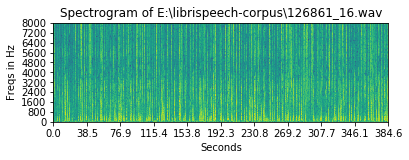

In [5]:
corpus_entry = random.choice(ls_corpus)
rate, audio = corpus_entry.audio
freqs, times, spec = log_specgram(audio, rate)
show_spectrogram(freqs, times, spec)

Such a spectrogram is now created as a matrix `x` for every single corpus entry. A label vector `y` is also created for each corpus entry. This leaves us with two files for each entry. Since the spectrograms can become quite big, separate files are created for each entry. The files share a common naming pattern to identify their type (spectrogram or label), subset membership (train-, dev- or test-set) and corresponding corpus entry (ID of the corpus entry):

`{id}.{X|Y}.{train|dev|test}.npy`

For example the following files will be created for a corpus entry in the dev-set with ID `1234`:

```
1234.X.dev.npy
1234.Y.dev.npy
```

### Creating the spectrograms and labels

Creating the labelled data might take some time (around 15 minutes for the ReadyLingua corpus up to several hours for the LibriSpeech corpus). Click the button below to start computing the spectrograms and label vectors.

In [6]:
display(widgets.HBox([create_data_rl_btn, create_data_ls_btn]))

HBox(children=(Button(button_style='info', description='Create labelled data for ReadyLingua', icon='download', layout=Layout(height='50px', width='250px'), style=ButtonStyle()), Button(button_style='info', description='Create labelled data for LibriSpeech', icon='download', layout=Layout(height='50px', width='250px'), style=ButtonStyle())))

## Exploring the labelled data
After the labelled data has been created, we can explore a sample by visualizing its spectrogram together with the information from the label vector. Execute the following cell to explore a random sample from the ReadyLingua corpus. In contrast to the spectrogram above this will not calculate the spectrogram on-the-fly but merely load the pre-computed files from disk. Together with the spectrogram the raw wave form will also be displayed. The labels (the information about pause segments) will be overlaid to both and will be visibile as r

In [ ]:
corpus_entry = random.choice(rl_corpus)
show_labelled_data(corpus_entry, rl_data_root)